# ARIMA (SARIMA)

The script aims to forecast the values of a time series using an ARIMA (or SARIMA) model. The series in question, which can be found on this [link](https://www3.bcb.gov.br/sgspub/consultarvalores/telaCvsSelecionarSeries.paint) represents the Retail Sales Volume Index in the state of São Paulo, Brazil, with monthly data from 2000 to 2022.

The model will be trained using the data up to December 2020 and then be capable of making predictions for the years 2021 and 2022.

The chosen evaluation metric is MAPE (Mean Absolute Percentage Error), which is commonly used to evaluate forecasts in time series. MAPE is calculated as the average of the absolute percentage differences between actual and predicted values relative to actual values.

The formula for MAPE is given by:

$MAPE = \large\frac{1}{n}\small * ∑\large|\large\frac{(Yi - Pi)}{Yi}|\small * 100$

Where:

- n is the number of observations
- $Y_i$ is the actual value of observation i
- $P_i$ is the predicted value of observation i

## Implementation

- Check the dataset for patterns of trend and seasonality.


- Test the stationarity of the data using the Dickey-Fuller test.


- Perform differencing on the series.


- Create and train the model.


- Obtain the forecasts.


- Perform reverse differencing.


- Analyze the obtained results (outputs).

***

### Checking Dataset

In [1]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
import datetime as dt
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Checking the data
df_retail = pd.read_csv(f'Data/retailsp.csv', index_col=0)
df_retail.head(5)

,value,Date
0,45.40,2000-01-01
1,46.52,2000-02-01
2,49.11,2000-03-01
3,47.99,2000-04-01
4,50.15,2000-05-01


In [3]:
# Transforming the Date column
df_retail['Date'] = pd.to_datetime(df_retail['Date'])

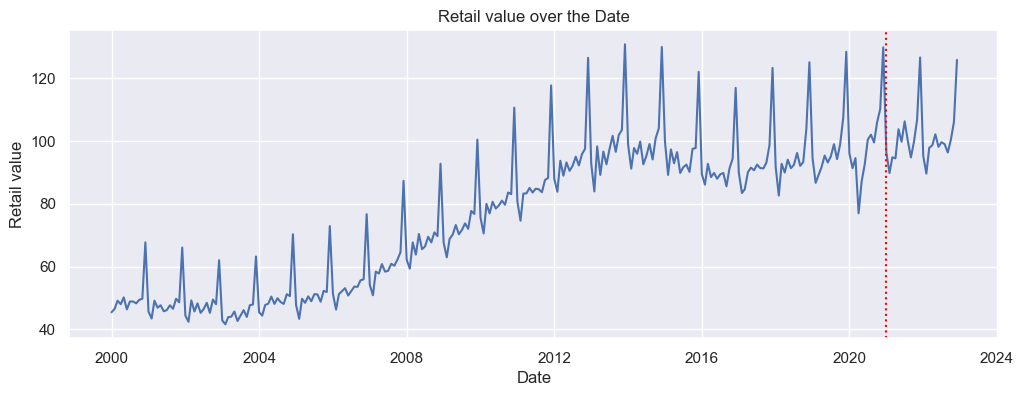

In [4]:
# Plotting the Retail Value over the Date
plt.figure(figsize=(12,4))
plt.plot(df_retail['Date'], df_retail['value'])
plt.xlabel('Date')
plt.ylabel('Retail value')
plt.title('Retail value over the Date')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

The dotted line indicates the point at which the forecasts will begin to be made.

By looking at the plot, it is clearly evident that there is a seasonal pattern in the data (which would indicate that the SARIMA model should be used instead of ARIMA). However, it might be interesting to perform a double-check by decomposing the series.

In [5]:
# Decomposing
decomposed_ts = sm.tsa.seasonal_decompose(df_retail['value'], period=12)

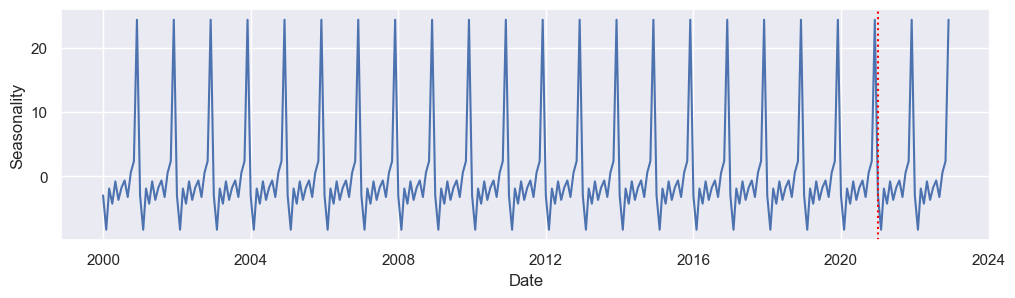

In [6]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_retail['Date'], decomposed_ts.seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

Decomposing the time series makes it even clearer that there is a seasonal component influencing the series on an annual basis, and this information should be considered in the model construction.

### Verifying stationarity

A stationary time series is one in which the statistical properties, such as mean, variance, and autocorrelation, do not change over time. In other words, the series maintains a consistent pattern and is not affected by trends, seasonality, or abrupt changes. The ARIMA model can only be applied to stationary series.

One way to test the stationarity of a series is by using the Dickey-Fuller test. This test helps determine whether a series is stationary by examining the presence of unit roots. If the test results in a p-value below a certain significance level (e.g., 0.05), it suggests that the series is stationary. Conversely, a p-value above the significance level indicates that the series is non-stationary and requires further treatment, such as differencing, to achieve stationarity.


In [7]:
# Dickey Fuller Test
adf_result = adfuller(df_retail['value'], maxlag=1)
adf_result

(-2.7477882845169717,
 0.06612753056152,
 1,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 2052.9793247884845)

The second value in the print is the p-value, which, being greater than 0.05, does not reject the null hypothesis, indicating that the series, under a 5% significance level, is stationary.

### Differencing the Series 

The series is not stationary; therefore, some form of treatment is necessary for applying the model.

The most commonly used treatment to remove non-stationary trends and patterns is differencing, which makes the series more suitable for modeling using the AR (autoregressive) and MA (moving average) components of ARIMA.

By applying differencing, it is possible to reduce the series' dependence on time and make it stationary in terms of mean and variance. This facilitates forecasting and modeling using ARIMA.

In [8]:
# Determining the number of differentiations required
diffs = ndiffs(df_retail['value'], test='adf')
diffs

1

The series requires 1 differentiation, which means that it is necessary to subtract the values of the series over a time interval to make it stationary.

In [9]:
# Differencing
dif_df_retail = np.diff(df_retail['value'])

In [10]:
# Checking the values after the differencing process
print(dif_df_retail[0:5])
print(df_retail['value'].loc[1:5].values -  df_retail['value'].loc[0:4].values)

[ 1.12  2.59 -1.12  2.16 -3.8 ]
[ 1.12  2.59 -1.12  2.16 -3.8 ]


As we can observe, the obtained values correspond to the subtraction of an original value by its previous value.

### Create and train the model

It will be necessary to split the differenced series into training and testing sets. This is done to create and adjust the model and later make predictions that can be compared with the original values.

In [11]:
# Getting the last value index
idx_split = df_retail.loc[df_retail['Date']==dt.datetime(2020,12,1)].index[0]

In [12]:
# Splitting the train and test values
train_values = dif_df_retail[0:idx_split]
test_values = dif_df_retail[idx_split:]

The model will be created using the auto_arima function, which performs an automatic search to determine the best parameters for the ARIMA model based on the training data. The 'trace' parameter is set to True to display information about the model.

The seasonal parameter, previously mentioned, should be added to the function, and 'm=12' sets the seasonal periodicity as 12, indicating an annual seasonality.

In [13]:
# Creating the model
arima_model = auto_arima(train_values, trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1122.677, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1204.164, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1147.754, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1125.504, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1202.164, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1120.883, Time=0.47 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1122.770, Time=1.08 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1122.728, Time=0.48 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1124.835, Time=1.73 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1119.281, Time=0.37 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1121.044, Time=0.43 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1121.144, Time=1.01 sec
 ARIMA(1,0,2)(1,1,0)[12] inte

The ARIMA(1,0,2)(0,1,1)[12] model was selected as the best model based on the automatic search performed. This model indicates that it has an autoregressive (AR) component of order 1, a moving average (MA) component of order 2, and a seasonal differencing component of order 1 with a period of 12 (indicating annual seasonality). These parameters were determined to be the most suitable for fitting the training data based on the Akaike Information Criterion (AIC).

After the selection, the model will be fitted to the training data using the determined parameters.

In [14]:
# Fit
arima_model.fit(train_values)

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [15]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  251
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -553.699
Date:                              Thu, 18 May 2023   AIC                           1117.397
Time:                                      15:06:44   BIC                           1134.779
Sample:                                           0   HQIC                          1124.402
                                              - 251                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8320      0.070    -11.906      0.000      -0.969      -0.695
ma.L1          0.3941      0.069      5.710      0.000       0.259       0.529
ma.L2         -0.5389      0.056     -9.671      0.000      -0.648      -0.430
ma.S.L12      -0.3916      0.088     -4.428      0.000      -0.565      -0.218
sigma2         5.9429      0.235     25.319      0.000       5.483       6.403
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1855.57
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               6.03   Skew:                            -1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Making predictions

The now fitted model will make predictions corresponding to the size of the test data.

In [16]:
# Predictions
y_pred = arima_model.predict(n_periods=len(test_values))

In [17]:
y_pred

array([-31.14321337,  -4.5976061 ,   2.5543397 ,  -9.29008186,
         6.73264452,   3.13710703,   4.87244311,   2.6713256 ,
        -3.49936867,   5.64675848,   5.59579917,  20.65459828,
       -31.53526566,  -4.98429846,   2.87607599,  -9.55777332,
         6.95536952,   2.95179508,   5.02662661,   2.54304164,
        -3.39263368,   5.55795269,   5.66968748,  20.59312162])

In [18]:
test_values

array([-33.57,  -6.53,   5.01,  -0.32,   9.29,  -4.  ,   6.52,  -6.14,
        -5.38,   4.97,   7.04,  19.89, -31.41,  -5.64,   8.19,   0.86,
         3.48,  -3.99,   1.48,  -0.64,  -2.65,   3.96,   5.82,  19.76])

Although the model's predictions may seem consistent with the test data, it is important to remember that these data are differenced and, therefore, the predictions do not correspond to the actual values of the dataset.

The usefulness of the model will need to be assessed after the reverse differencing procedure, where the predicted values can be compared with the actual values.

### Reverse differencing

The way to obtain reverse differentiation is by taking the last value of the training series and adding the values obtained from the predictions.

In [19]:
# Getting the train database last value
train_last_value = df_retail['value'].loc[idx_split]
train_last_value

129.92

In [20]:
# Getting the reversed predictions
r_pred = np.r_[train_last_value, y_pred].cumsum()[1:]

### Analyzing the results

Once the predicted values have undergone the reverse differentiation process, their values can be compared with those of the training dataset.

The Mean Absolute Percentage Error (MAPE) will be the metric used to evaluate the performance of the model.

In [21]:
# Predicted and real values
df_test = df_retail.loc[idx_split+1:]
df_test['predicted_value'] = r_pred
df_test[['Date', 'value', 'predicted_value']]

,Date,value,predicted_value
252,2021-01-01,96.35,98.776787
253,2021-02-01,89.82,94.179181
254,2021-03-01,94.83,96.733520
255,2021-04-01,94.51,87.443438
256,2021-05-01,103.80,94.176083
257,2021-06-01,99.80,97.313190
258,2021-07-01,106.32,102.185633
259,2021-08-01,100.18,104.856959
260,2021-09-01,94.80,101.357590
261,2021-10-01,99.77,107.004348


In [22]:
# Getting MAPE
print(f"MAPE: {round((np.mean(abs((df_test['value'] - df_test['predicted_value'])/df_test['value']))),4) * 100}% ")

MAPE: 5.91% 


A MAPE of 5.91% indicates that, on average, the model's predictions have a mean absolute percentage error of 5.91% compared to the actual values in the training dataset. A lower MAPE value indicates better model performance, as it indicates that the predictions are closer to the actual values. Therefore, a MAPE of 5.91% is considered a positive result, indicating good accuracy in the predictions.

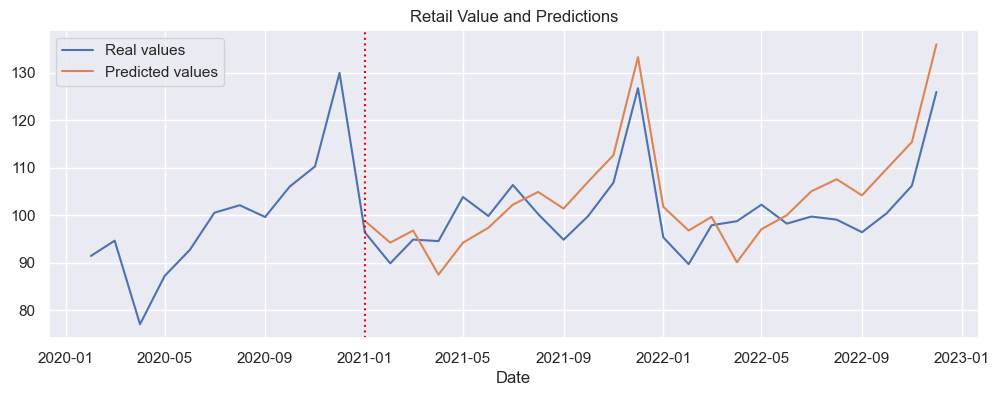

In [23]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_retail['Date'].loc[df_retail['Date']>dt.datetime(2020, 1, 1)], df_retail['value'].loc[df_retail['Date']>dt.datetime(2020, 1, 1)])
plt.plot(df_test['Date'], df_test['predicted_value'])
plt.xlabel('Date')
plt.title('Retail Value and Predictions')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.legend(['Real values', 'Predicted values'])
plt.show();

As we can see from the graph, the model made accurate predictions of the Retail Index for the state of São Paulo.

### Conclusion


The conclusion that can be drawn from applying the ARIMA model to the dataset is that the final predictions were good, with a mean error of 5.91%. Some information, such as the presence of seasonality and the verification that the data needed to be differenced using the Dickey Fuller test, was necessary for the optimal fit of the model.